In [ ]:
import os
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt

from diffEq import odes, plot

## Test differential equation:

$\frac{dT(t)}{dt} = r(T_{env} - T(t))$



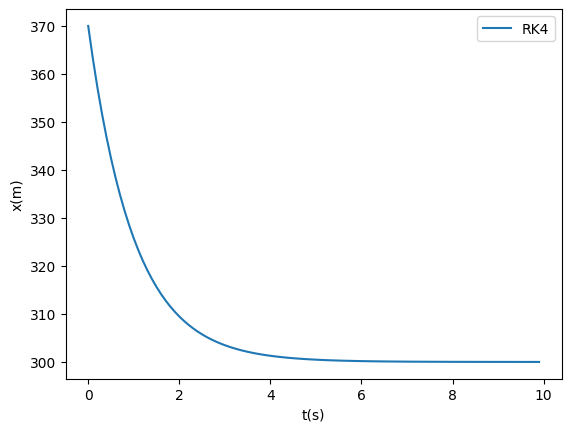

In [ ]:
r = 1
T_env = 300

# args = [T]
def DT(t, args):
    return r*(T_env - args[0])

cooling_obj = odes([DT], [370])

t_list, T_list = cooling_obj.solve_Runge_Kutta(0, 10, h=0.1, stage=4)
solutions = {"RK4": (t_list, T_list)}

plot(solutions)

# Elements to change to test model architecture

- n_step: Number of time points when simulating T(t)
- n_exp: Number of experiment to train model on
- n_train: Number of points used for training
- Number of hidden layers
- Number of neurons per hidden layer
- nn.Linear (other?)
- Activation function (now tanh)
- Loss function: Now nn.MSELoss(), Means Squared Error:
$ 
\begin{equation}
MSE = \frac{1}{N}\sum_{i=1}^{N}\left(y_i - \tilde{y}_i\right)^2
\end{equation}
$
- Optimizer and its parameters: Now optim.Adam
- The number of epochs (number of times we adapt the weights and biases)

## Getting device for training

In [ ]:
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
    print(device)

## Preparing data

Here we create synthetic data to test the model architecture. In real life (in a real experiment) we get our data and then apply our model to it. But now since we want to build a model, we create synthetic data to train it (and test it). So in real life of course we don't know T(t) exactly since this is what we want to calculate with our ML model.

In [ ]:
n_step = 200 #number of time points when simulating T(t)
n_exp = 500 #number of experiment to train model on
n_train = 400

#For each of the 100 experiments we now have a unique (r, T_env, T_0) triplet
torch.manual_seed(0) #get the same random numbers everytime you run the code
r_tensor = torch.rand(n_exp, 1) #random cooling rate between 0 and 1 (100 times)
T_env_tensor = torch.rand(n_exp, 1) * 500 #random ambient temperature between 0 and 500 (100 times)
T_0_tensor = T_env_tensor + torch.rand(n_exp, 1) * 100 #Initial temperature, slightly higher than the ambient temperature (between 0K and 100K hotter) (100 times)


t_tensor = torch.linspace(0, 50, n_step) #n_step (100) equally spaced time points between 0 and 50 seconds
T_tensor = T_env_tensor - (T_env_tensor - T_0_tensor)*torch.exp(-r_tensor * t_tensor) #creates 100 * 100 points, where each experiment has its own sampled datapoints (from exact solution)

# Split data into training and test sets
r_train, T_env_train, T_0_train, T_train = r_tensor[:n_train], T_env_tensor[:n_train], T_0_tensor[:n_train], T_tensor[:n_train]
X_train = torch.cat((r_train, T_env_train, T_0_train), 1) #C_train is a 90*3 tensor containing input features for training

#Standardize training inputs X_norm = X-µ/std, so each feature (column) has mean 0 and std1
X_train_mean = X_train.mean(dim=0, keepdim=True)
X_train_std = X_train.std(dim=0, keepdim=True)
X_train = (X_train - X_train_mean) / X_train_std

#Do the same for test data
r_test, T_env_test, T_0_test, T_test = r_tensor[n_train:], T_env_tensor[n_train:], T_0_tensor[n_train:], T_tensor[n_train:]
X_test = torch.cat((r_test, T_env_test, T_0_test), 1)

X_test_mean = X_test.mean(dim=0, keepdim=True)
X_test_std = X_test.std(dim=0, keepdim=True)
#X_test = (X_test - X_test_mean) / X_test_std       #test 1
X_test = (X_test - X_train_mean) / X_train_std


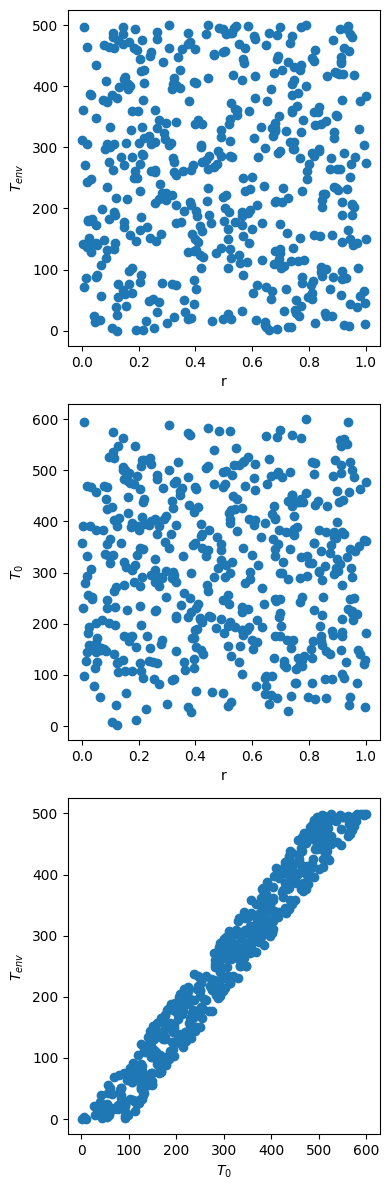

In [ ]:
#Check if we cover the phase space evenly
fig, ax = plt.subplots(3,1, figsize = (4,12))

ax[0].scatter(r_tensor, T_env_tensor)
ax[0].set_xlabel("r")
ax[0].set_ylabel(r"$T_{env}$")

ax[1].scatter(r_tensor, T_0_tensor)
ax[1].set_xlabel("r")
ax[1].set_ylabel(r"$T_0$")

ax[2].scatter(T_0_tensor, T_env_tensor)
ax[2].set_xlabel(r"$T_0$")
ax[2].set_ylabel(r"$T_{env}$")

plt.tight_layout()
plt.show()

## Defining the model

In [ ]:
class CoolingModel(nn.Module):
    def __init__(self, n_step):
        super().__init__()
        self.fc1 = nn.Linear(3, 32)    # Takes input vectors of size 3 (r, T_env, T_0) and outputs 32 hidden features
        self.fc2 = nn.Linear(32, n_step)  # Maps 32 hidden features to output of size n_size (predicted temperature curve over time)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))     # smooth activation
        x = self.fc2(x)
        return x

# Initiate the model
model = CoolingModel(n_step) #creates a model object using the class, with the chosen number of time steps

In [ ]:
# Loss function and optimizer
loss_func = nn.MSELoss() #mean square error loss (measures average squared difference between predicted value and true targets) (what the ML model wants to minimize)

#optimizer = optim.SGD(model.parameters(), lr=0.01)
#optimizer = optim.Adam(model.parameters(), lr=0.001) #New optimizer

#optimizer = optim.Adam(which weights/biases to update, Learning rate — controls the step size for updates, L2 regularization - prevents weights from growing too large (better generalization))
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4) #updates model parameters based on the gradients computed from the loss

## Train the model

In [ ]:
# Training loop with learning curve tracking
train_losses = []
test_losses = []

epochs = 50000 #One complete pass through entire training dataset (update weights 20000 times)

for epoch in range(epochs):
    T_pred = model(X_train) #forward pass
    
    loss = loss_func(T_pred, T_train) #compute loss

    #compute other losses for the learning curve (make this faster?)
    T_pred_test = model(X_test)
    test_loss = loss_func(T_pred_test, T_test).item()
    train_losses.append(loss.item()) #add to train_losses for learning curve
    test_losses.append(test_loss) #add to test_losses for learning curve

    optimizer.zero_grad() #reset gradients
    loss.backward() #compute gradients of the loss
    
    optimizer.step() #update parameters

    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 100/50000, Loss: 10.3092
Epoch 200/50000, Loss: 10.3014
Epoch 300/50000, Loss: 10.2933
Epoch 400/50000, Loss: 10.2852
Epoch 500/50000, Loss: 10.2768
Epoch 600/50000, Loss: 10.2681
Epoch 700/50000, Loss: 10.2593
Epoch 800/50000, Loss: 10.2503
Epoch 900/50000, Loss: 10.2414
Epoch 1000/50000, Loss: 10.2326
Epoch 1100/50000, Loss: 10.2245
Epoch 1200/50000, Loss: 10.2170
Epoch 1300/50000, Loss: 10.2105
Epoch 1400/50000, Loss: 10.2051
Epoch 1500/50000, Loss: 10.2002
Epoch 1600/50000, Loss: 10.1960
Epoch 1700/50000, Loss: 10.1922
Epoch 1800/50000, Loss: 10.1889
Epoch 1900/50000, Loss: 10.1851
Epoch 2000/50000, Loss: 10.1817
Epoch 2100/50000, Loss: 10.1782
Epoch 2200/50000, Loss: 10.1747
Epoch 2300/50000, Loss: 10.1714
Epoch 2400/50000, Loss: 10.1680
Epoch 2500/50000, Loss: 10.1649
Epoch 2600/50000, Loss: 10.1614
Epoch 2700/50000, Loss: 10.1579
Epoch 2800/50000, Loss: 10.1545
Epoch 2900/50000, Loss: 10.1512
Epoch 3000/50000, Loss: 10.1477
Epoch 3100/50000, Loss: 10.1445
Epoch 3200/50000,

In [ ]:
model.eval()
with torch.no_grad():
    T_pred_test = model(X_test)
    test_loss = loss_func(T_pred_test, T_test)
    print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 7.5293


In [ ]:
for name, param in model.named_parameters():
    print(name, param.data)

fc1.weight tensor([[  0.0674, -16.9299,   1.4009],
        [  0.0315,  -0.3943,  -0.3689],
        [ -0.0315,   0.3943,   0.3689],
        [ -0.2683,  -2.3676,  -0.1683],
        [ -0.0556, -11.1208,   1.2760],
        [ -1.9821,  -3.9700,   4.1901],
        [  0.4995,   4.3583,  -1.5196],
        [ -0.2723,  -5.6521,   1.8068],
        [ -0.0315,   0.3943,   0.3689],
        [  0.0315,  -0.3943,  -0.3689],
        [  0.2739,  -4.1661,   4.9377],
        [  0.0315,  -0.3943,  -0.3689],
        [ -0.0624,  -0.1985,  -1.1688],
        [ -0.0315,   0.3943,   0.3689],
        [  0.3316,   5.7604,  -2.5399],
        [  0.0315,  -0.3943,  -0.3689],
        [  0.0315,  -0.3943,  -0.3689],
        [  0.0933,   4.3539,  -1.4542],
        [  0.0830,   2.4613,  -2.8871],
        [  0.0315,  -0.3943,  -0.3689],
        [ -0.0315,   0.3943,   0.3689],
        [  0.1047,  -5.6406,   0.4407],
        [  0.2498,  -4.4622,   0.8459],
        [  0.3541,  -4.0448,   0.6485],
        [  0.2983,  -4.1775, 

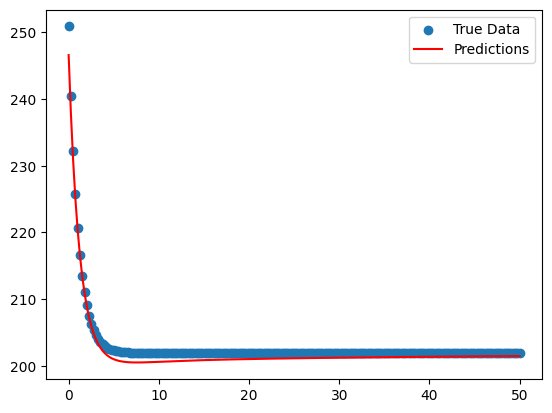

In [ ]:
plt.scatter(t_tensor, T_test[-1], label="True Data")
plt.plot(t_tensor, T_pred_test[-1], color="red", label="Predictions")
plt.legend()
plt.show()

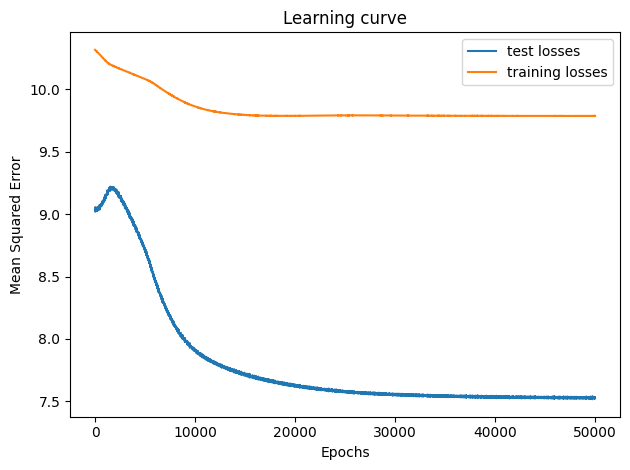

In [ ]:
#compute the learning curve
epochs_array = np.linspace(0, epochs, epochs)

plt.plot(epochs_array, test_losses, label="test losses")
plt.plot(epochs_array, train_losses, label = "training losses")
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Learning curve')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()